<a href="https://colab.research.google.com/github/YusrilHasanuddin/BATIK-WGAN-WGAN-GP/blob/main/WGAN_Two_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/YusrilHasanuddin/BatikGAN.git

Cloning into 'BatikGAN'...
remote: Enumerating objects: 517, done.
remote: Counting objects: 100% (517/517), done.
remote: Compressing objects: 100% (505/505), done.
remote: Total 517 (delta 15), reused 505 (delta 8), pack-reused 0
Receiving objects: 100% (517/517), 45.12 MiB | 36.99 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
!mkdir data
!mv BatikGAN/dataset_batik/* data
!ls data

mkdir: cannot create directory ‘data’: File exists
Patch  Real-Image


In [4]:
!ls data/Patch

 0051-cl_A.jpg
 0051-cl_B.jpg
 0167-sample-solo-jateng-btk-s76-L410b_A.jpg
 0167-sample-solo-jateng-btk-s76-L410b_B.jpg
 0175-cl_A.jpg
 0175-cl_B.jpg
 0179-cl_A.jpg
 0179-cl_B.jpg
 06-nitik-randu-seling_A.jpg
 06-nitik-randu-seling_B.jpg
'10agt 147_A.jpg'
'10agt 147_B.jpg'
 bar-101-batik-yogya-tulis-rakitan-kawung-benggol-ceplok-nogo_A.jpg
 bar-101-batik-yogya-tulis-rakitan-kawung-benggol-ceplok-nogo_B.jpg
 batik-cap-motif-nitik_A.jpg
 batik-cap-motif-nitik_B.jpg
 batik_Grompol_motif_w_A.jpg
 batik_Grompol_motif_w_B.jpg
 Batik-Nitik-Brendi_A.jpg
 Batik-Nitik-Brendi_B.jpg
 batik-tulis-nitik-3_A.jpg
 batik-tulis-nitik-3_B.jpg
 bbr-004-batik-yogya-kombinasi-rakitan-putri-solo_A.jpg
 bbr-004-batik-yogya-kombinasi-rakitan-putri-solo_B.jpg
 ceplok-bintang_A.jpg
 ceplok-bintang_B.jpg
 ceplok-bligon1_A.jpg
 ceplok-bligon1_B.jpg
 ceplok-ganggong_A.jpg
 ceplok-ganggong_B.jpg
 Kawung-Putih-coklat1_A.jpg
 Kawung-Putih-coklat1_B.jpg
'[K]CeplokNitik-S[T]_A.jpg'
'[K]CeplokNitik-S[T]_B.jpg'
 kotak-kaw

## Import

In [5]:
data_dir = "data/"
dataset_dir = "data/Patch/"


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

from matplotlib import pyplot as plt
import numpy as np

import os

## Data

In [7]:
train_images = tf.keras.utils.image_dataset_from_directory(
    dataset_dir, label_mode=None, image_size=(64, 64), batch_size=128 # update from 32
)

Found 326 files belonging to 1 classes.


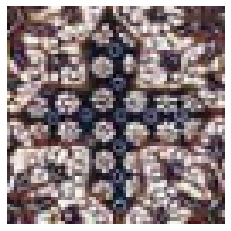

In [8]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [9]:
def show(images):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(images[i]) 
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

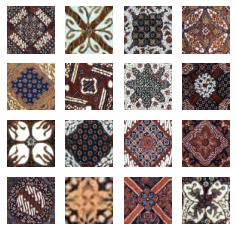

In [10]:
# Visualize 16 images from the training dataset
show(image_batch[:16])

In [11]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images: we feed random noise as input to the generator and upsample it till the desired image size becomes 64x64x3.

In [12]:
# latent dimension of the random noise
LATENT_DIM = 64 
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3  

## Data Pipeline

In [13]:
class DataPipeline:
    def __init__(self):
        # self.path = path
        self

    def load_data(self, path, size):
        list_img = list()
        for filename in os.listdir(path):
                # load and resize the image
            img = image.load_img(path + filename, target_size=size)
            # convert to numpy array
            img = image.img_to_array(img)
            # Convert to lower case
            path_file = (path + filename).lower()
            # store
            list_img.append([path_file, img])
        img_sorted = sorted(list_img)
        img_arr = np.asarray([i[1] for i in img_sorted])

        return img_arr

    def concat_image(self, patch_a, patch_b):
        def h(patch_a, patch_b):
            h = tf.concat([patch_a, patch_b, patch_a, patch_b], 1)
            return h
        v = tf.concat([h(patch_a, patch_b), h(patch_b, patch_a), 
                       h(patch_a, patch_b), h(patch_b, patch_a)], 2)
        return v

    def normalisasi(self, A, B):
        A = tf.cast(A, dtype=tf.float32)
        A = (A-127.5)/127.5
        B = tf.cast(B, dtype=tf.float32)
        B = (B-127.5)/127.5
        img = self.concat_image(tf.expand_dims(A, axis=0), 
                                tf.expand_dims(B, axis=0))[0]
        return A, B, img

    def execute(self):
        # dataset = self.load_data()
        path = data_dir
        data_patch = self.load_data(path + 'Patch/', (64, 64))

        patch_a = data_patch[[i for i in range(326) if i % 2 == 0]]
        patch_b = data_patch[[i for i in range(326) if i % 2 != 0]]

        dataset = tf.data.Dataset.from_tensor_slices((patch_a, patch_b))

        # # AUTOTUNE = tf.data.experimental.AUTOTUNE
        dataset = dataset.map(self.normalisasi, num_parallel_calls=-1).cache()
        dataset = dataset.batch(1, drop_remainder=True).repeat(1)
        dataset = dataset.prefetch(1)
        return dataset

In [14]:
dataset = DataPipeline().execute()

In [15]:
dataset

<PrefetchDataset shapes: ((1, 64, 64, 3), (1, 64, 64, 3), (1, 256, 256, 3)), types: (tf.float32, tf.float32, tf.float32)>

In [16]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))
    

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [17]:
# build the generator model
generator = build_generator() 

In [18]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             2129920   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

## The Critic
In WGAN we have a critic instead of a discriminator.
If you are updating a DCGAN to a WGAN, you can use the “Find and replace” in Colab for the updates.


In [19]:
# UPDATE for WGAN: a new class implementing weight clipping constraint
class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

In [20]:
def build_critic(height, width, depth, alpha=0.2):
    #UPDATE for WGAN: enfoce 1-Lipschitz constraint with weight clippping to [-1, 1] 
    constraint = WeightClipping(0.01)

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint, # UPDATE for WGAN
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2), 
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) 

    # UPDATE for WGAN: linear activation in the last layer. 
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

In [21]:
# build the critic model
critic = build_critic(64, 64, 3) 

In [22]:
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0    

## WGAN

Subclass `keras.Model` to implement WGAN and override `train_step()` to implement custom training steps for training the critic and generator in WGAN.

In [23]:
class WGAN(keras.Model):
    def __init__(self, 
                 critic, 
                 generator, 
                 latent_dim, 
                 critic_extra_steps): # UPDATE
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN: remove the code of real / fake labels
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # UPDATE for WGAN: we train the critic more often than the generator by 5 times (self.c_extra_steps) 
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images 
            with tf.GradientTape() as tape:
                # Get the critic' predictions on the real images
                pred_real = self.critic(real_images, training=True)
                # Generate fake images from the latent noise
                fake_images = self.generator(noise, training=True) 
                # Get the critic' predictions on the fake images
                pred_fake = self.critic(fake_images, training=True)
                # Calculate the critic loss with wassertein loss function
                d_loss = self.d_loss_fn(pred_real, pred_fake)
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake) 
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [24]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        sequence = [i for i in range(163)]
        _patchA = list([img[0] for img in list(dataset.as_numpy_iterator())])[0] #[random.choice(sequence)]
        _patchB = list([img[1] for img in list(dataset.as_numpy_iterator())])[0] #[random.choice(sequence)]
        generated_images = self.model.generator([_patchA, 
                                                 _patchB])

        if (epoch+1)%20==0:
            _, ax = plt.subplots(1, 3, figsize=(10, 10))
            ax[0].imshow((_patchA[0]+1)/2)
            ax[1].imshow((_patchB[0]+1)/2)
            ax[2].imshow((generated_images[0]+1)/2)
            ax[0].set_title("Input image A")
            ax[1].set_title("Input image B")
            ax[2].set_title("Translated image")
            ax[0].axis("off")
            ax[1].axis("off")
            ax[2].axis("off")

            plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Compile and Train WGAN

Compile the `wgan` model with the `RMSprop` optimizer (a learning rate of 0.00005) as recommended by the paper, and the **Wasserstein loss** 

### Putting together the `wgan` model

In [25]:
wgan = WGAN(critic=critic, 
              generator=generator, 
              latent_dim=LATENT_DIM,
              critic_extra_steps=5) # UPDATE for WGAN

### Wasserstein loss

In [26]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

### Compile WGAN

In [27]:
LR = 0.00005 # UPDATE for WGAN: learning rate per WGAN paper

In [28]:
wgan.compile(
    d_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    g_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

### Train WGAN

Now we simply call `model.fit()` to train the `wgan` model!

In [29]:
#NUM_EPOCHS = 1000 # number of epochs
#wgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

In [30]:
NUM_EPOCHS = 1000
WEIGHT_LOSS = {'adversarial':1, 
               'local_l2':1, 
               'style_loss':10, 
               'adversarial_local':100, 
               'local_style_loss':1,
               'content_loss':0}
LIST_WEIGHT_CONTENT_LOSS = [1,10,100]

##Tailor Two Patches

In [31]:
for _WEIGHT_CONTENT_LOSS in LIST_WEIGHT_CONTENT_LOSS:
    VERSION = "ContentLoss-{}".format(_WEIGHT_CONTENT_LOSS) # Version
    print('--- Starting training: {}'.format(VERSION))
    WEIGHT_LOSS['content_loss'] = _WEIGHT_CONTENT_LOSS
    wgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

--- Starting training: ContentLoss-1
Epoch 1/1000
3/3 [==============================] - ETA: 0s - d_loss: -0.0071 - g_loss: 0.0062 

ValueError: ignored